<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.0

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


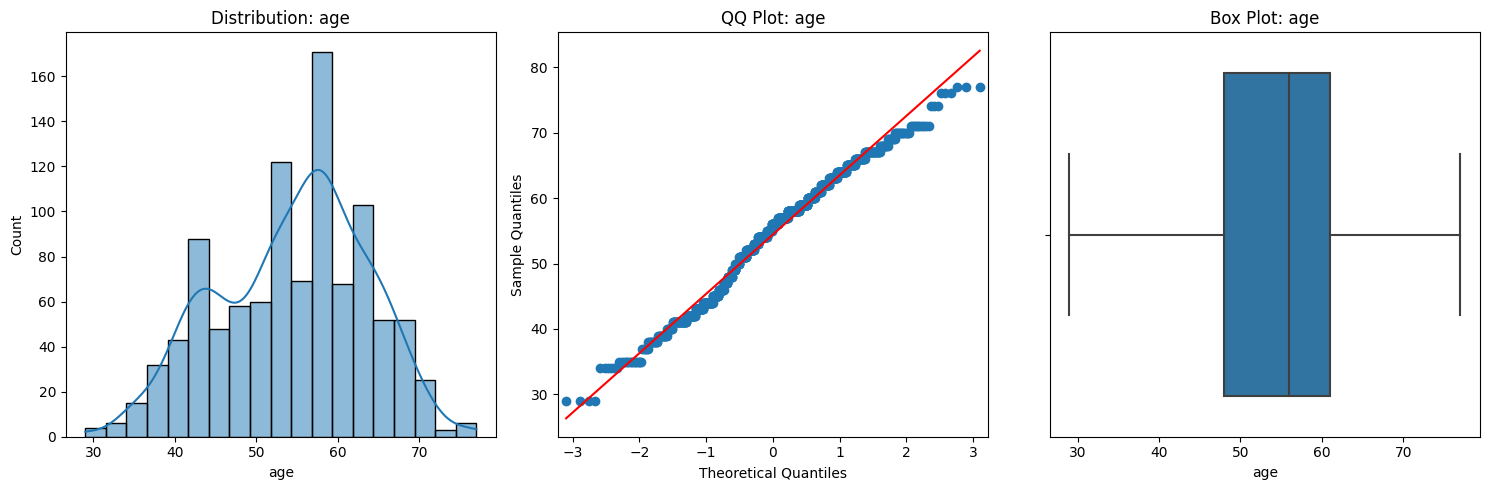

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


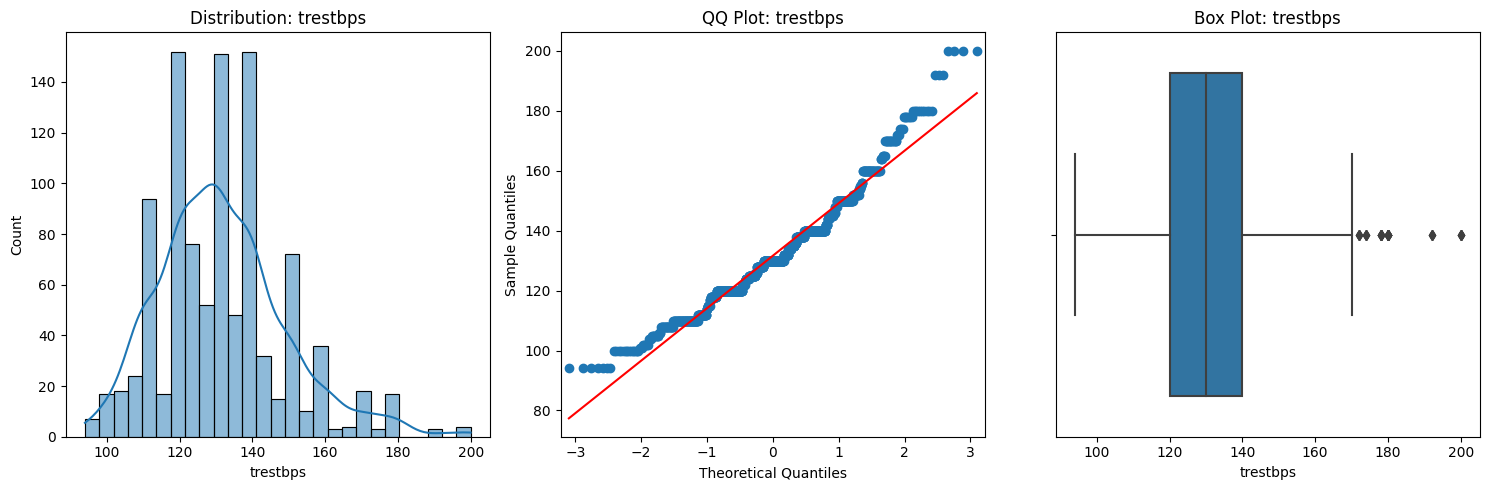

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


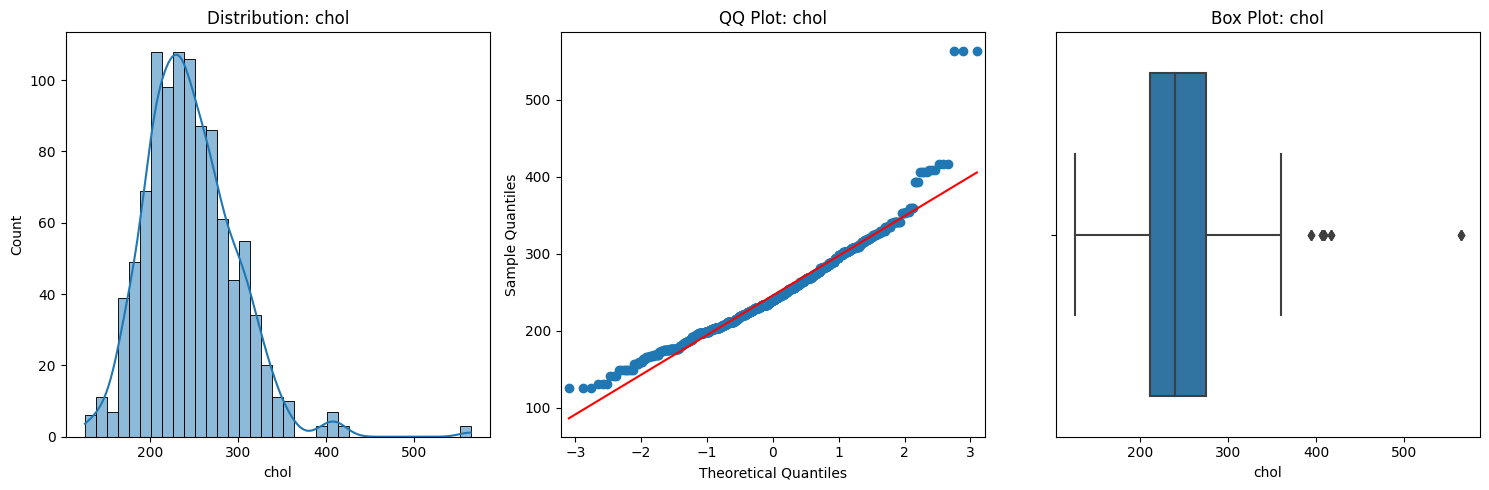

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


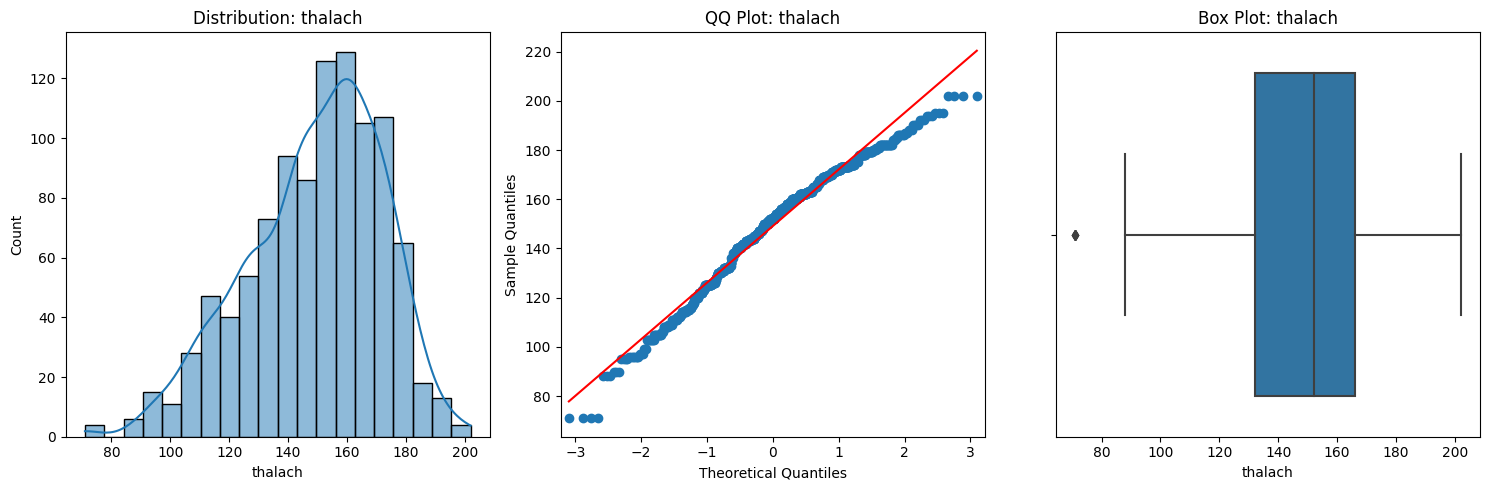

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


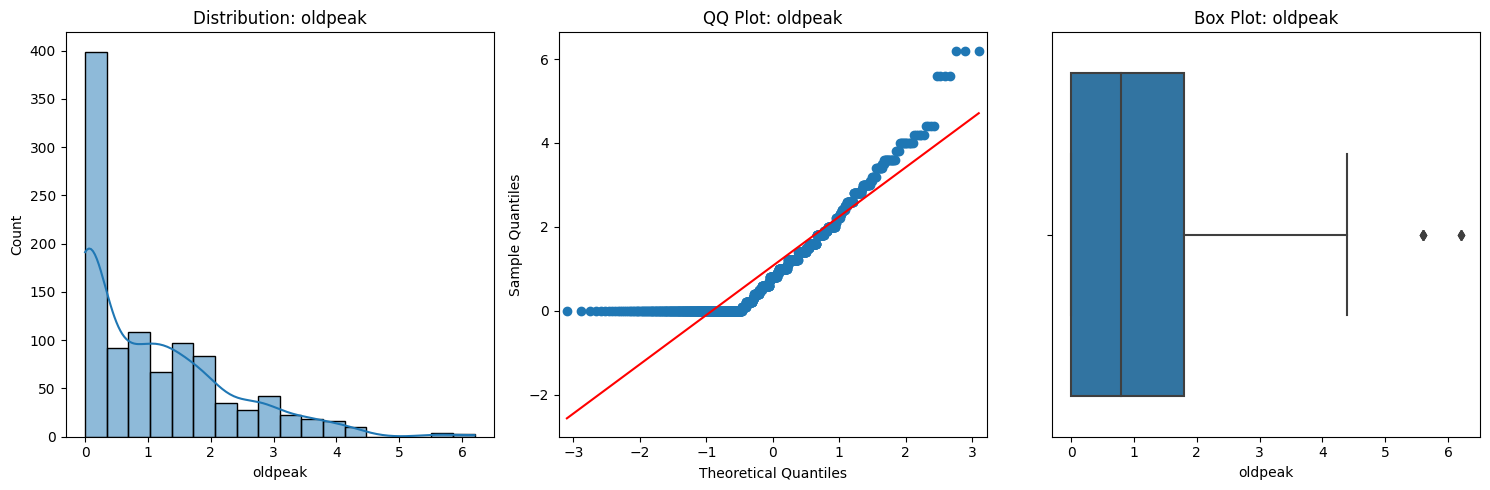

/tmp/ipykernel_35/1009413381.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '130.0924623115578' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[column] > upper, column] = valid_mean
/tmp/ipykernel_35/1009413381.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '242.98315163528247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[column] > upper, column] = valid_mean
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


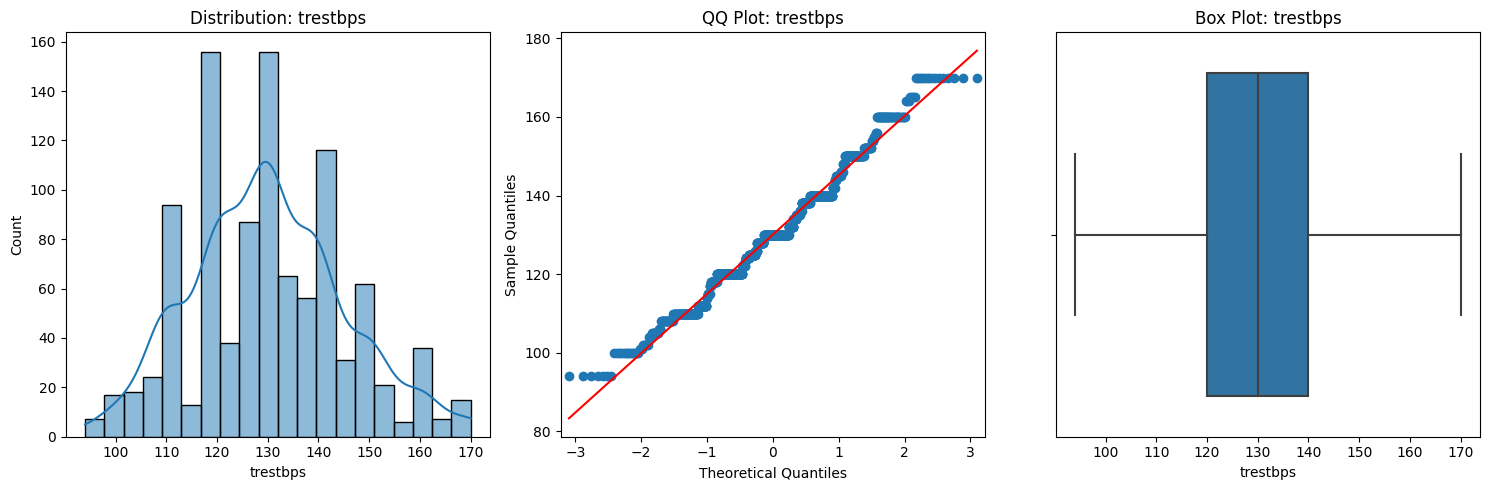

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


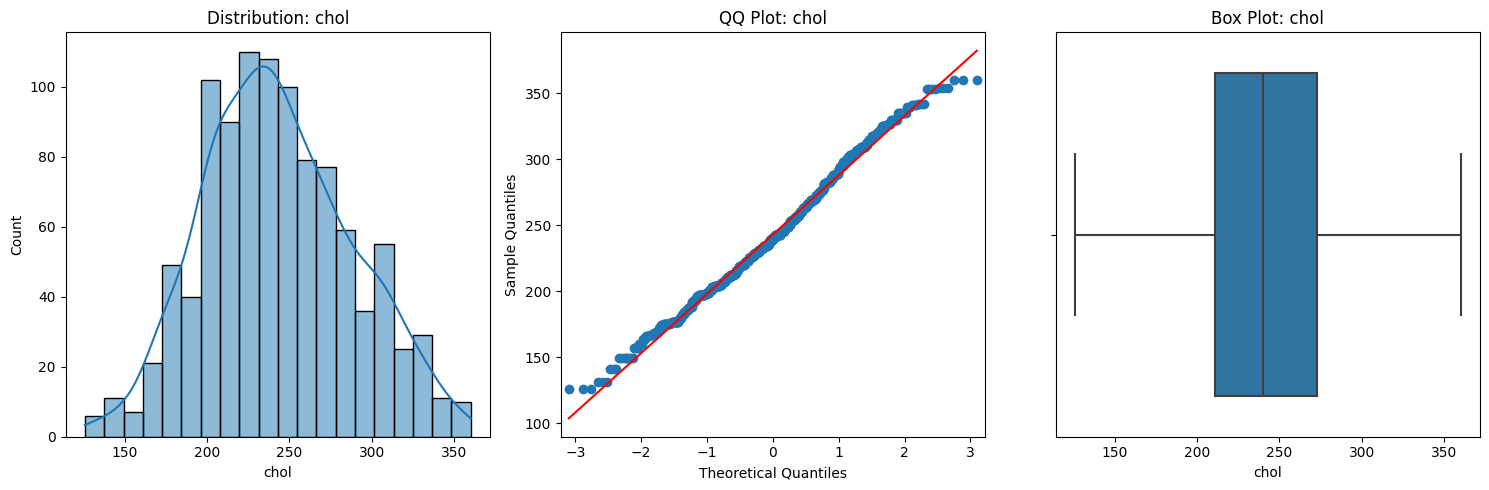

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


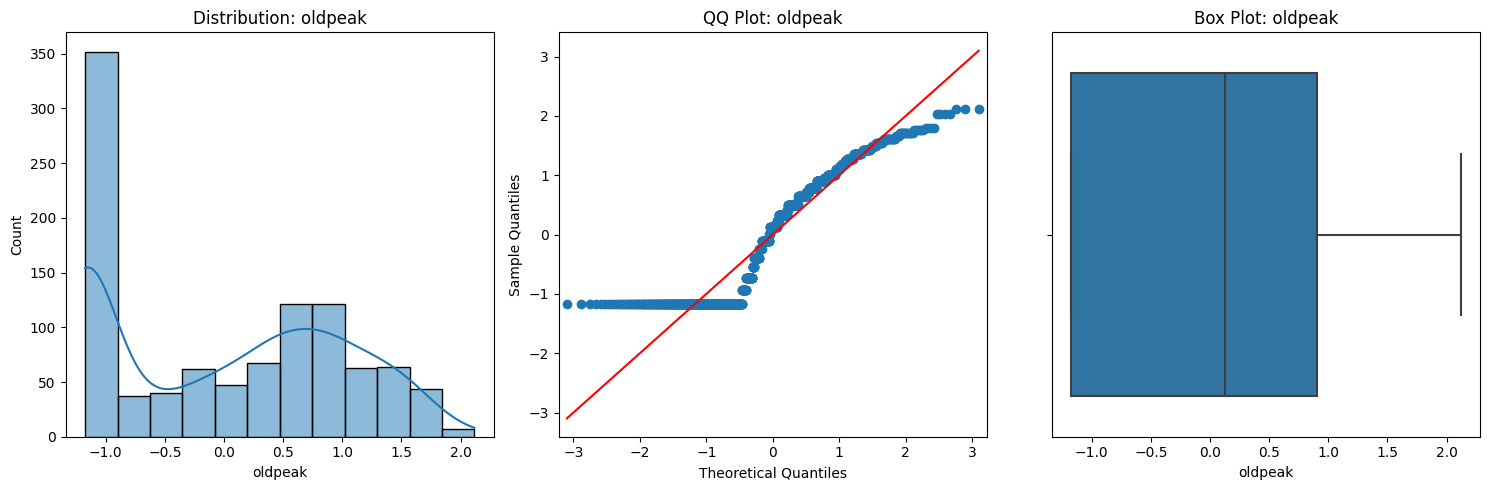

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Confusion Matrix:
 [[100   0]
 [  0 105]]
Model saved to heart_disease_xgb_model.joblib


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


def load_data(csv_path: str) -> pd.DataFrame:
    """
    
    Load the dataset from a CSV file and return a pandas DataFrame.
    """
    return pd.read_csv(csv_path)


def explore_columns(data: pd.DataFrame, columns: list[str]) -> None:
    """
    Generate distribution, QQ, and box plots for specified numerical columns.
    """
    for col in columns:
        if col not in data.columns or data[col].dtype not in ["int64", "float64"]:
            print(f"Skipping '{col}': not found or not numeric.")
            continue

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        sns.histplot(data[col], ax=axes[0], kde=True)
        axes[0].set_title(f"Distribution: {col}")

        sm.qqplot(data[col], line='s', ax=axes[1])
        axes[1].set_title(f"QQ Plot: {col}")

        sns.boxplot(x=data[col], ax=axes[2])
        axes[2].set_title(f"Box Plot: {col}")

        plt.tight_layout()
        plt.show()


def cap_outliers(data: pd.DataFrame, column: str) -> None:
    """
    Cap outliers above 1.5*IQR by replacing them with the column's non-outlier mean.
    """
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr

    valid_mean = data.loc[data[column] <= upper, column].mean()
    data.loc[data[column] > upper, column] = valid_mean


def transform_feature(data: pd.DataFrame, column: str) -> None:
    """
    Apply Yeo-Johnson power transform to make the feature more Gaussian-like.
    """
    pt = PowerTransformer()
    arr = data[column].values.reshape(-1, 1)
    data[column] = pt.fit_transform(arr).flatten()


def train_and_evaluate(data: pd.DataFrame, target: str) -> XGBClassifier:
    """
    Split data, perform grid search for XGBoost classifier, print metrics, and return the best model.
    """
    features = data.drop(columns=[target])
    labels = data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, stratify=labels, random_state=42
    )

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_params = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 200, 300]
    }

    search = GridSearchCV(estimator=xgb, param_grid=grid_params, cv=5)
    search.fit(X_train, y_train)

    print("Best parameters:", search.best_params_)
    preds = search.predict(X_test)
    print("\nClassification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

    return search.best_estimator_


def main():
    # Load dataset
    data_dir = '/kaggle/input/heart-disease-dataset'
    csv_file = os.path.join(data_dir, 'heart.csv')
    data = load_data(csv_file)

    # Initial data overview
    print(data.info())
    print(data.describe())

    # Exploratory plots for key features
    explore_columns(data, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'])

    # Handle outliers in blood pressure and cholesterol
    for col in ['trestbps', 'chol']:
        cap_outliers(data, col)
    explore_columns(data, ['trestbps', 'chol'])

    # Normalize skewed feature
    transform_feature(data, 'oldpeak')
    explore_columns(data, ['oldpeak'])

    # Train model and evaluate results
    model = train_and_evaluate(data, target='target')

    # Save trained model for later use
    model_path = 'heart_disease_xgb_model.joblib'
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")


if __name__ == '__main__':
    main()
